Clustering hashtags and profiles

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('coolwarm')
%matplotlib inline

In [2]:
profile_df = pd.read_csv('Business Analytics/tagged_profiles.csv')

In [3]:
profile_df.drop(columns=['std_eng','tot_eng'],inplace=True)

In [4]:
profile_df.isna().sum()

avg_eng       0
max_eng       0
min_eng       0
n_posts       0
profile       0
followers    22
dtype: int64

In [5]:
profile_df[profile_df['followers'].isna()]

,avg_eng,max_eng,min_eng,n_posts,profile,followers
254,557778.149079,898784,185328,597,@t,NaN
325,640673.500000,674301,602258,4,@malcolmbrogdon,NaN
356,632593.909091,785478,351591,11,@sdinwiddie_2508,NaN
383,641382.500000,786020,538730,4,@nvonleh,NaN
406,620243.000000,656399,584087,2,@keefmorris5,NaN
449,732310.666667,829056,657395,3,@jonasjerebko8,NaN
468,710571.000000,710571,710571,1,@_dameology,NaN
518,593913.714286,869434,226327,56,@kevindurant,NaN
587,411664.000000,411664,411664,1,@trey_duval,NaN
588,451514.000000,484029,418999,2,@utahjazzsl,NaN


In [6]:
profile_df.fillna(0,inplace=True)

In [7]:
profile_df[profile_df['followers'].isna()]

,avg_eng,max_eng,min_eng,n_posts,profile,followers


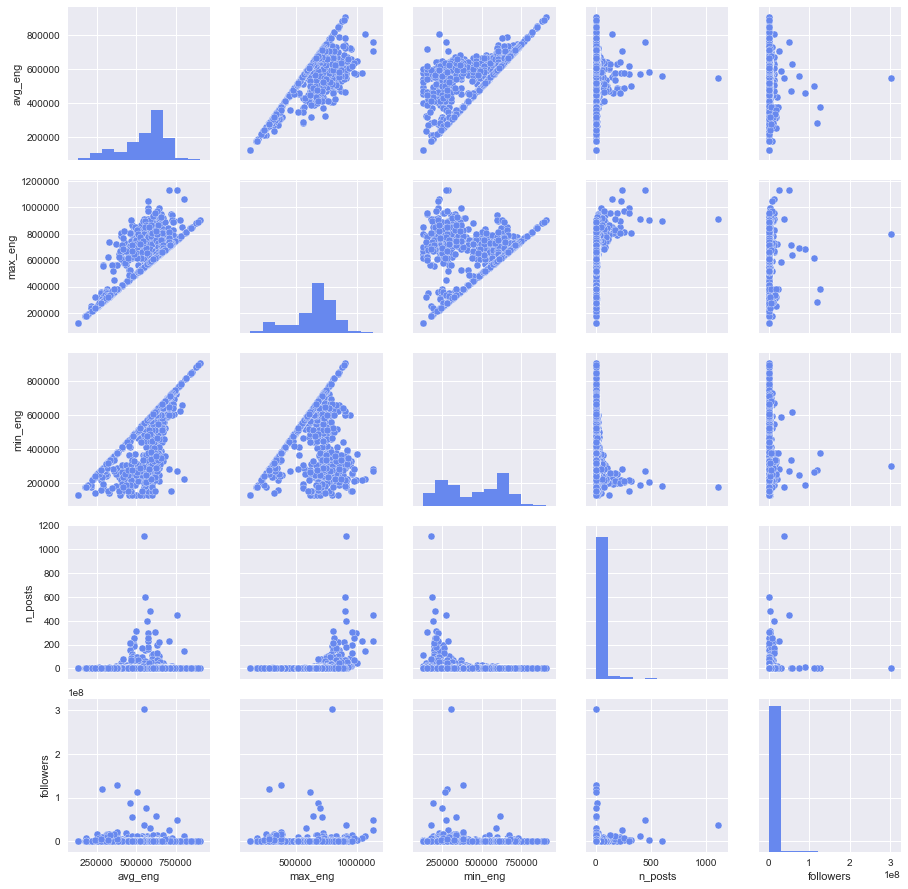

In [8]:
sns.pairplot(profile_df)

Now log transform n posts and followers, and normalize both datasets. 

In [9]:
profile_df['followers'] = np.log10(profile_df['followers']+1)
profile_df['n_posts'] = np.log10(profile_df['n_posts'])

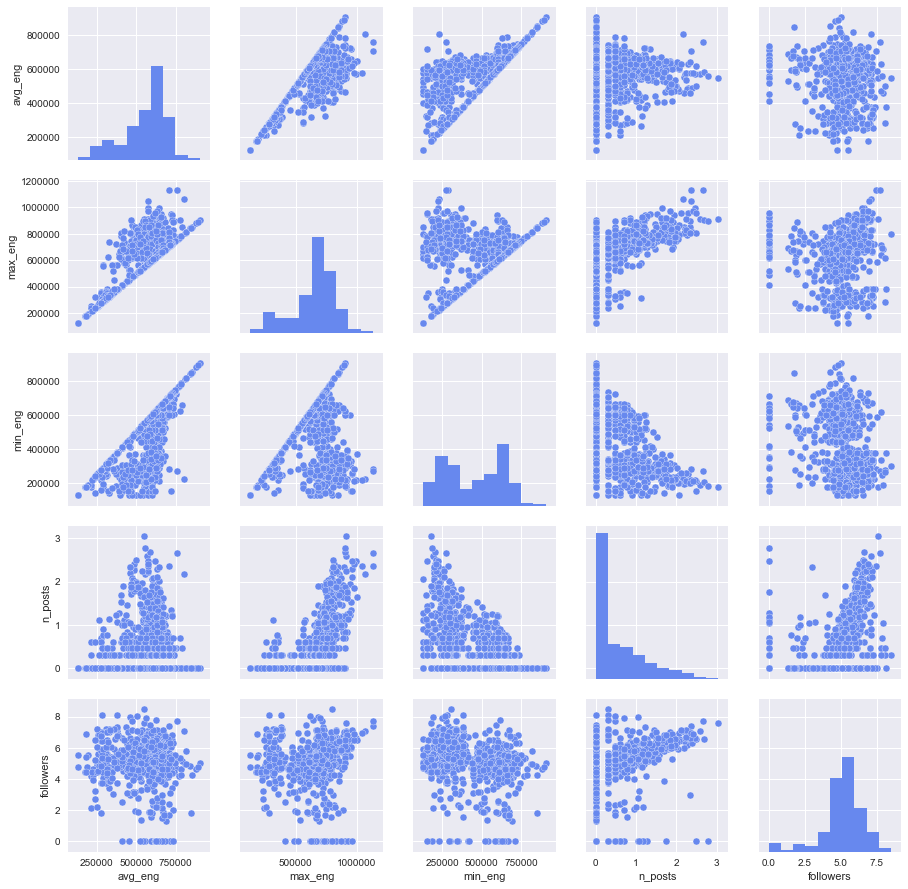

In [10]:
sns.pairplot(profile_df)

We now see a correlation between # of times a player is posted about on the nba insta, and how many followers he has. That's huge

In [11]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

x = profile_df.drop('profile',axis=1).values #returns a numpy array #removes missing followers (broken accounts)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


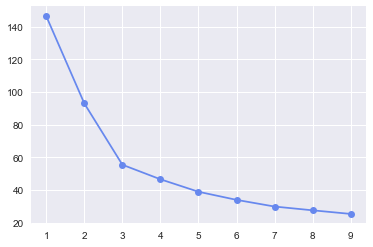

In [12]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    distortions.append(kmeanModel.inertia_)

plt.plot(K,distortions,'o-')

In [13]:
kmeanModel = KMeans(n_clusters=3).fit(df)

In [14]:
profile_df.dropna(subset=['followers'],inplace=True)
profile_df['Cluster'] = kmeanModel.labels_

In [15]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 762
Data columns (total 7 columns):
avg_eng      763 non-null float64
max_eng      763 non-null int64
min_eng      763 non-null int64
n_posts      763 non-null float64
profile      763 non-null object
followers    763 non-null float64
Cluster      763 non-null int32
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 44.7+ KB


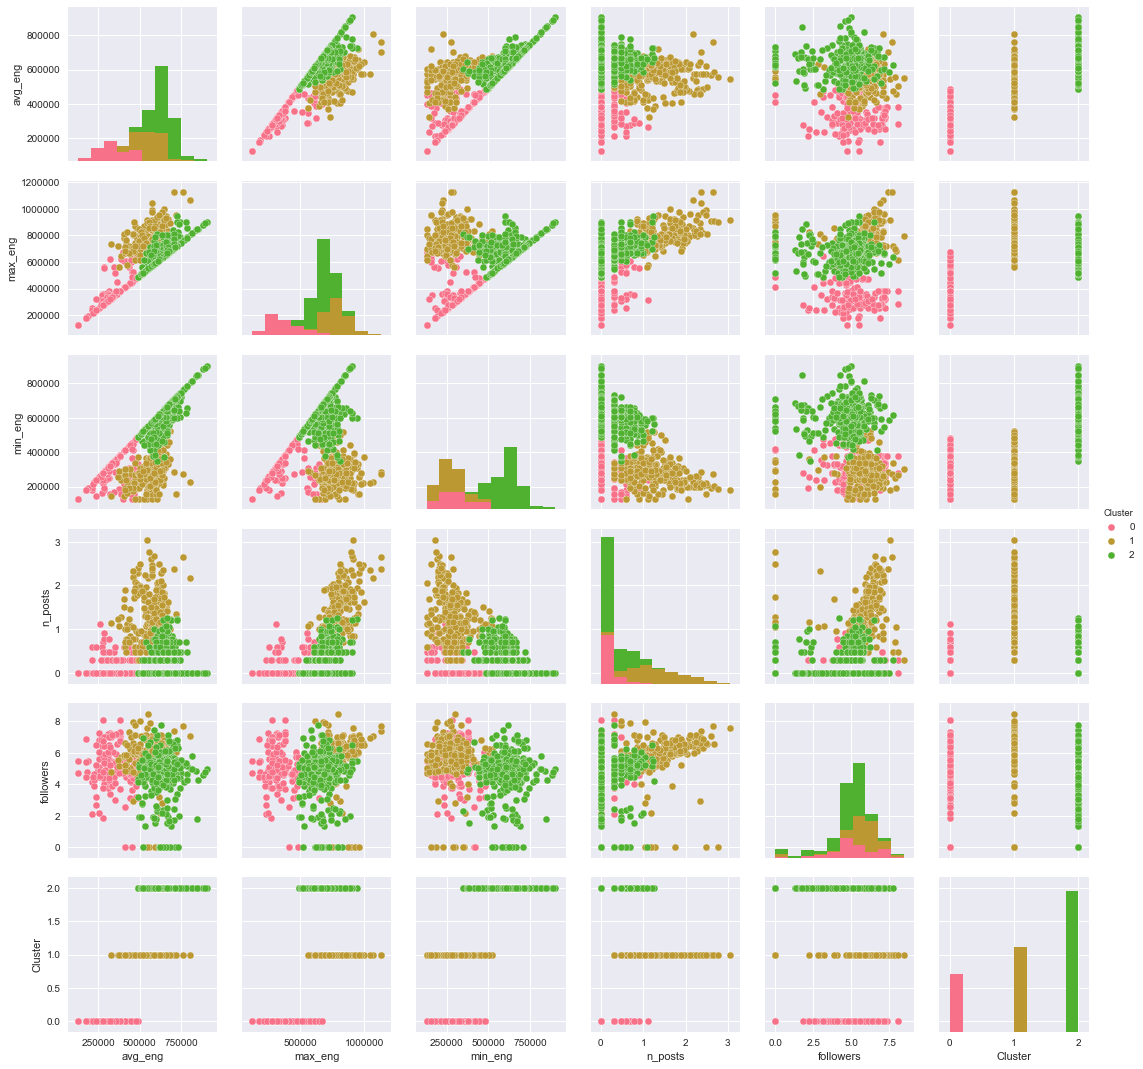

In [16]:
sns.set_palette('husl')
sns.pairplot(profile_df.drop('profile',axis=1),hue='Cluster')

In [17]:
profiles = profile_df[['profile','Cluster']].copy()
profiles = pd.get_dummies(profiles,columns=['Cluster'])

In [18]:
def apply_profile_clusters_to_training(z,profiles):
    """Apply the clusters to the dataset, now in a form for prediction aligned with the other data. 
   
   """
    
    import re
    from numpy import zeros
    post_clusters = zeros(profiles.shape[1] - 1)
    tags_in_z =  list( dict.fromkeys(re.findall('@[a-z_0-9]*',z)) ) 
    
    if len(tags_in_z) == 0:
        return post_clusters
    for tag_in_z in tags_in_z:
        try:
            post_clusters = post_clusters + profiles[profiles['profile'] == tag_in_z].values[0][1:] 
        except: 
            pass
    return post_clusters

In [19]:
instas = pd.read_csv('Business Analytics/training_set.csv',encoding = 'unicode_escape')

instas.fillna('',inplace=True)
instas['Clusters'] = instas['Description'].str.lower().apply(lambda z: apply_profile_clusters_to_training(z,profiles))
clusters = pd.DataFrame(instas.Clusters.tolist(), columns=['profiles_nC1', 'profiles_nC2','profiles_nC3'])

In [20]:
instas.head()

,Engagements,Followers at Posting,Created,Type,Description,Clusters
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,"[0.0, 2.0, 2.0]"
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,"[0.0, 2.0, 0.0]"
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,"[0.0, 2.0, 0.0]"
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,"[0.0, 0.0, 0.0]"
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,"[0.0, 1.0, 0.0]"


In [21]:
instas = instas.merge(clusters,left_index=True,right_index=True).drop('Clusters',axis=1)

Now do the same for hashtags

In [22]:
hashtag_df = pd.read_csv('Business Analytics/used_hashtags.csv')

In [23]:
#hashtag_df.drop(columns=['max_eng','min_eng'],inplace=True)

In [24]:
hashtag_df.describe()

,avg_eng,max_eng,min_eng,n_posts,# of posts
count,349.000000,3.490000e+02,349.000000,349.000000,3.490000e+02
mean,548651.251942,6.707301e+05,436995.893983,19.945559,3.690869e+06
std,156909.969454,2.070708e+05,197142.570119,122.299730,3.438073e+07
min,159402.000000,1.594020e+05,127816.000000,1.000000,0.000000e+00
25%,427726.727273,5.840870e+05,282827.000000,1.000000,6.620000e+02
50%,569414.000000,6.953270e+05,353418.000000,2.000000,6.999000e+03
75%,668808.000000,8.072740e+05,617781.000000,8.000000,1.128640e+05
max,952816.000000,1.129585e+06,952816.000000,2118.000000,4.893160e+08


In [25]:
hashtag_df.isna().sum()

avg_eng       0
hashtags      0
max_eng       0
min_eng       0
n_posts       0
# of posts    0
dtype: int64

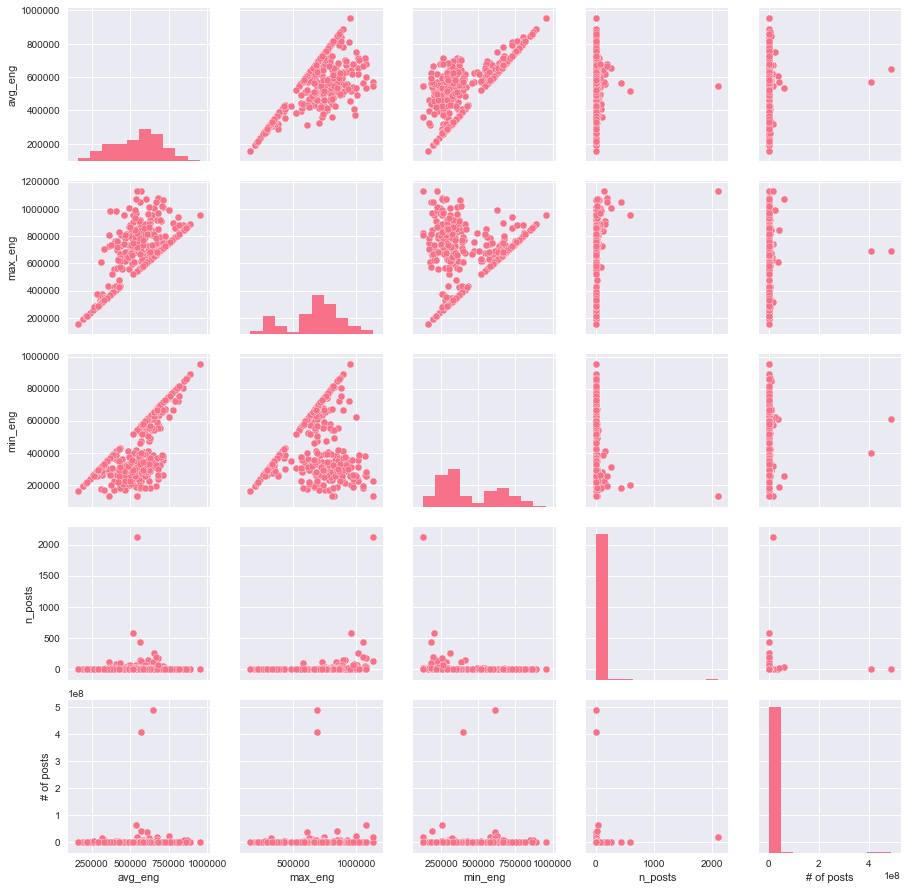

In [26]:
sns.pairplot(hashtag_df)

In [27]:
hashtag_df['# of posts'] = np.log10(hashtag_df['# of posts'] + 1)
hashtag_df['n_posts'] = np.log10(hashtag_df['n_posts'])

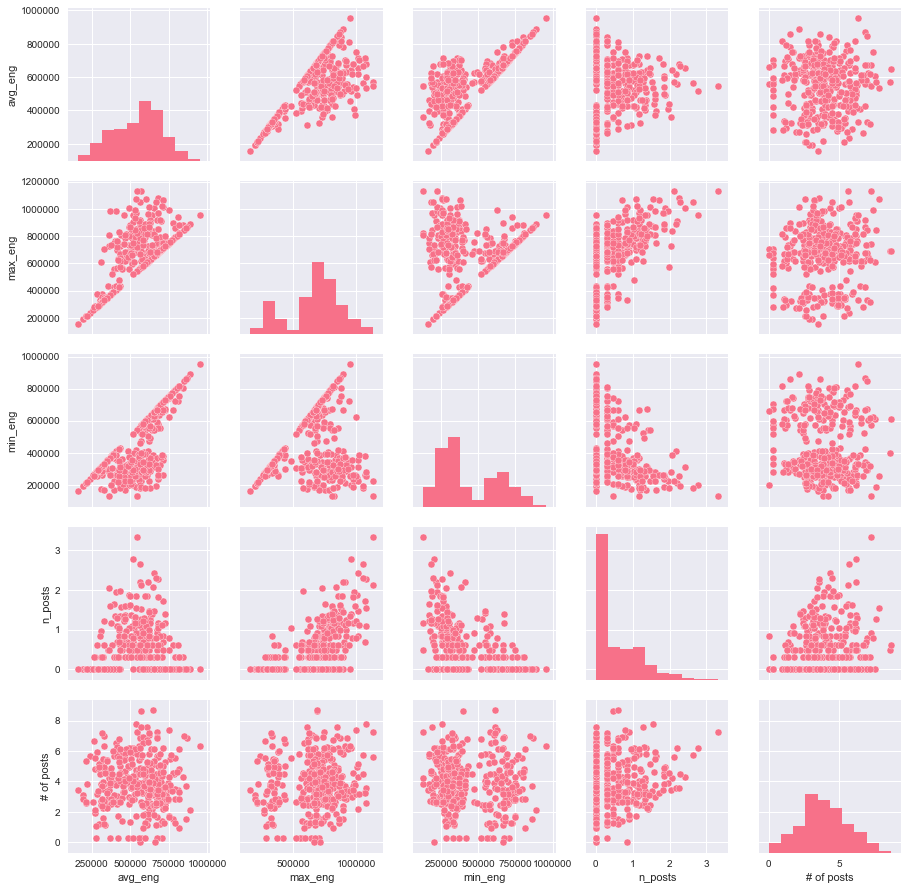

In [28]:
sns.pairplot(hashtag_df)

In [29]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

x = hashtag_df.drop('hashtags',axis=1).values #returns a numpy array #removes missing followers (broken accounts)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


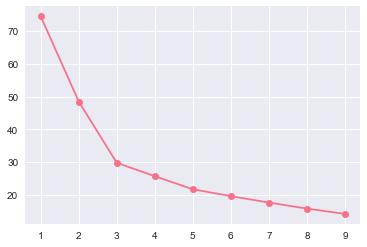

In [30]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    distortions.append(kmeanModel.inertia_)

plt.plot(K,distortions,'o-')

In [31]:
kmeanModel = KMeans(n_clusters=3).fit(df)

In [32]:
hashtag_df['Cluster'] = kmeanModel.labels_

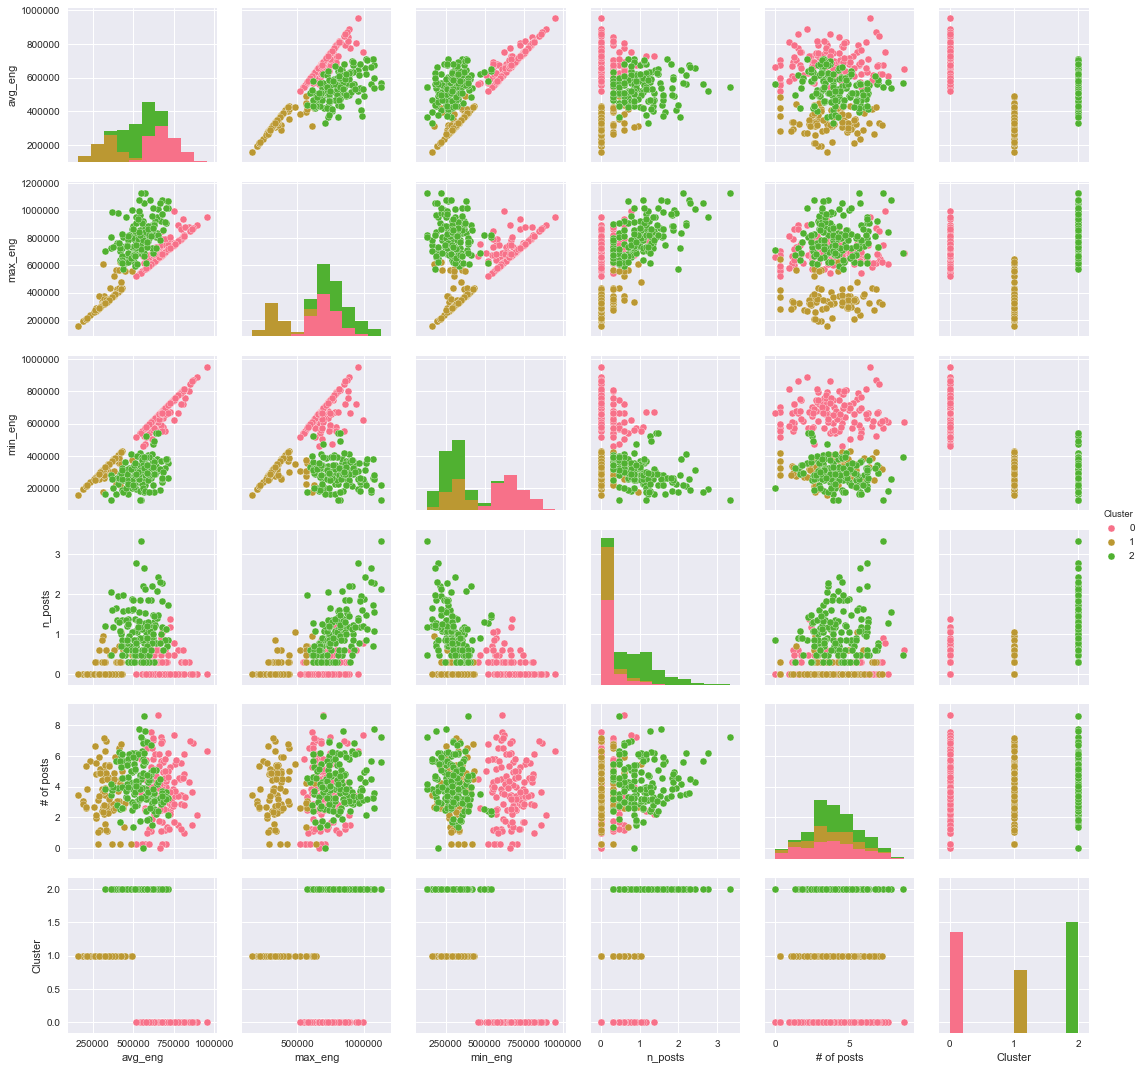

In [33]:
sns.pairplot(hashtag_df,hue='Cluster')

In [34]:
hashtags = hashtag_df[['hashtags','Cluster']].copy()
hashtags = pd.get_dummies(hashtags,columns=['Cluster'])

In [35]:
def apply_hashtag_clusters_to_training(z,hashtags):
    """Apply the clusters to the dataset, now in a form for prediction aligned with the other data. 
   
   """
    
    import re
    from numpy import zeros
    post_clusters = zeros(hashtags.shape[1] - 1)
    tags_in_z =  list( dict.fromkeys(re.findall('#[a-z_0-9]*',z)) ) 
    
    if len(tags_in_z) == 0:
        return post_clusters
    for tag_in_z in tags_in_z:
        #try:
        post_clusters = post_clusters + hashtags[hashtags['hashtags'] == tag_in_z].values[0][-(hashtags.shape[1] - 1):] 
       # except: 
       #     pass
    return post_clusters

In [36]:
hashtags.shape[1] -1

3

In [37]:
instas['HashtagClusters'] = instas['Description'].str.lower().apply(lambda z: apply_hashtag_clusters_to_training(z,hashtags))


In [38]:
clusters = pd.DataFrame(instas.HashtagClusters.tolist(), columns=['hashtags_nC1', 'hashtags_nC2','hashtags_nC3'])

In [62]:
#instas = instas.merge(clusters,left_index=True,right_index=True).drop('HashtagClusters',axis=1)
instas = pd.read_csv('Business Analytics/training_set.csv',encoding = 'unicode_escape')

instas.fillna('',inplace=True)

In [63]:
instas['Description_Len'] = instas['Description'].apply(len)
instas['num@s'] = instas['Description'].apply(lambda z: z.count('@'))
instas['num#s'] = instas['Description'].apply(lambda z: z.count('#'))
instas['num?s'] = instas['Description'].apply(lambda z: z.count('?')) # a shitty proxy for emojis

In [64]:
buzzer_beater_words = ['buzz','beat','clock']
dunk_words = ['slam','jam','finish','dunk']

def find_dunks(z):
    dunk_words = ['slam','jam','finish','dunk']
    for dw in dunk_words:
        if dw in z: 
            return 1
    return 0

def find_buzzer_beaters(z):
    buzzer_beater_words = ['buzz','beat','clock']
    
    for bbw in buzzer_beater_words:
        if bbw in z:
            return 1
    return 0
instas['Buzzer Beater?'] = instas['Description'].apply(lambda z: find_buzzer_beaters(z)) #shitty proxy for buzzer beaters
instas['Dunk?'] = instas['Description'].apply(lambda z:  find_dunks(z)) #shitty proxy for buzzer beaters


# Modeling time!

In [65]:
import datetime


In [66]:
instas['Timezone'] = instas['Created'].str.split(' ',expand =True)[2]
instas['Date'] = instas['Created'].str.split(' ',expand = True)[0]
instas['Month'] = instas['Date'].str.split('-',expand = True)[1]

instas['Time'] = instas['Created'].str.split(' ',expand = True)[1]
instas['Hour'] = instas['Time'].str.split(':',expand=True)[0]

instas['Date'] = pd.to_datetime(instas['Date']).astype(datetime.datetime)

instas['Weekday'] = instas['Date'].apply(lambda z: z.weekday())
instas['Year'] = instas['Created'].apply(lambda z: z.split('-')[0])

In [67]:
instas['Description']

0       The @raptors bench trio of @sergeibaka @norman...
1       @kyle_lowry7 pulls from deep for the @raptors ...
2          @k_mid22 with some english on the @bucks dime!
3             Kawhi punches it home with the left on TNT!
4       @giannis_an34 goes baseline early to rock the ...
5       Congrats to the 2018-19 NBA All-Rookie First T...
6       The @warriors locked in for four games to adva...
7       Will the @bucks take a commanding 3-1 lead... ...
8       TAP to SHOP the @warriors Western Conference C...
9       Hey @stephencurry30... that was the first time...
10      @stephencurry30 (37/13/11) & @money23green (18...
11      The @warriors defeat @trailblazers 119-117 to ...
12      @money23green (18/14/11) reacts to a 5th strai...
13      The @warriors win the West & advance to their ...
14      @money23green triple extends the @warriors lea...
15      @stephencurry30 & @money23green become the fir...
16                     ?? @meyersleonard11! ?? (??: ESPN)
17      @money

In [68]:
instas.drop(columns=['Date','Time'],inplace=True)

In [69]:
instas.describe()

,Engagements,Followers at Posting,Description_Len,num@s,num#s,num?s,Buzzer Beater?,Dunk?,Weekday
count,7.766000e+03,7.766000e+03,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000
mean,5.923129e+05,3.042770e+07,69.053953,1.509014,0.599536,1.019057,0.018285,0.072495,3.081767
std,1.792682e+05,3.748957e+06,37.143360,1.124158,0.716520,2.521439,0.133988,0.259323,1.970062
min,1.278160e+05,2.487554e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.173900e+05,2.698910e+07,44.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,6.397285e+05,3.004747e+07,63.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,7.216282e+05,3.392854e+07,88.000000,2.000000,1.000000,1.000000,0.000000,0.000000,5.000000
max,1.129585e+06,3.698468e+07,639.000000,10.000000,5.000000,34.000000,1.000000,1.000000,6.000000


In [70]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [71]:
X = instas.drop(columns=['Engagements','Description','Created','Followers at Posting','Timezone']).copy()



In [72]:
X = pd.get_dummies(X)

In [73]:
X_norm  = normalize(X)

In [74]:
y = instas['Engagements']

In [75]:
from sklearn.linear_model import LinearRegression

from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import GradientBoostingRegressor

In [76]:
import xgboost as xgb

In [77]:
model = xgb.XGBRegressor()

In [78]:
#model = RandomForestRegressor(n_estimators=25)
from random import choice

In [95]:


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3)

model = xgb.XGBRegressor(n_estimators=550,booster='dart')#choice(models)
print("Model used: ", model)
model.fit(X_train,y_train)
print("Training score: ", model.score(X_train,y_train))
print("Original Score", model.score(X_test,y_test))

def mean_absolute_percentage_error(y_true, y_pred):
    import numpy as np
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.array([round(y) for y in y_pred])

print("MAPE Original Score ", mean_absolute_percentage_error(y_true, y_pred))


Model used:  XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=550,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Training score:  0.9403436983709764
Original Score 0.9337058659041912
MAPE Original Score  5.461535855452333


In [96]:
instas.columns

Index(['Engagements', 'Followers at Posting', 'Created', 'Type', 'Description',
       'Description_Len', 'num@s', 'num#s', 'num?s', 'Buzzer Beater?', 'Dunk?',
       'Timezone', 'Month', 'Hour', 'Weekday', 'Year'],
      dtype='object')

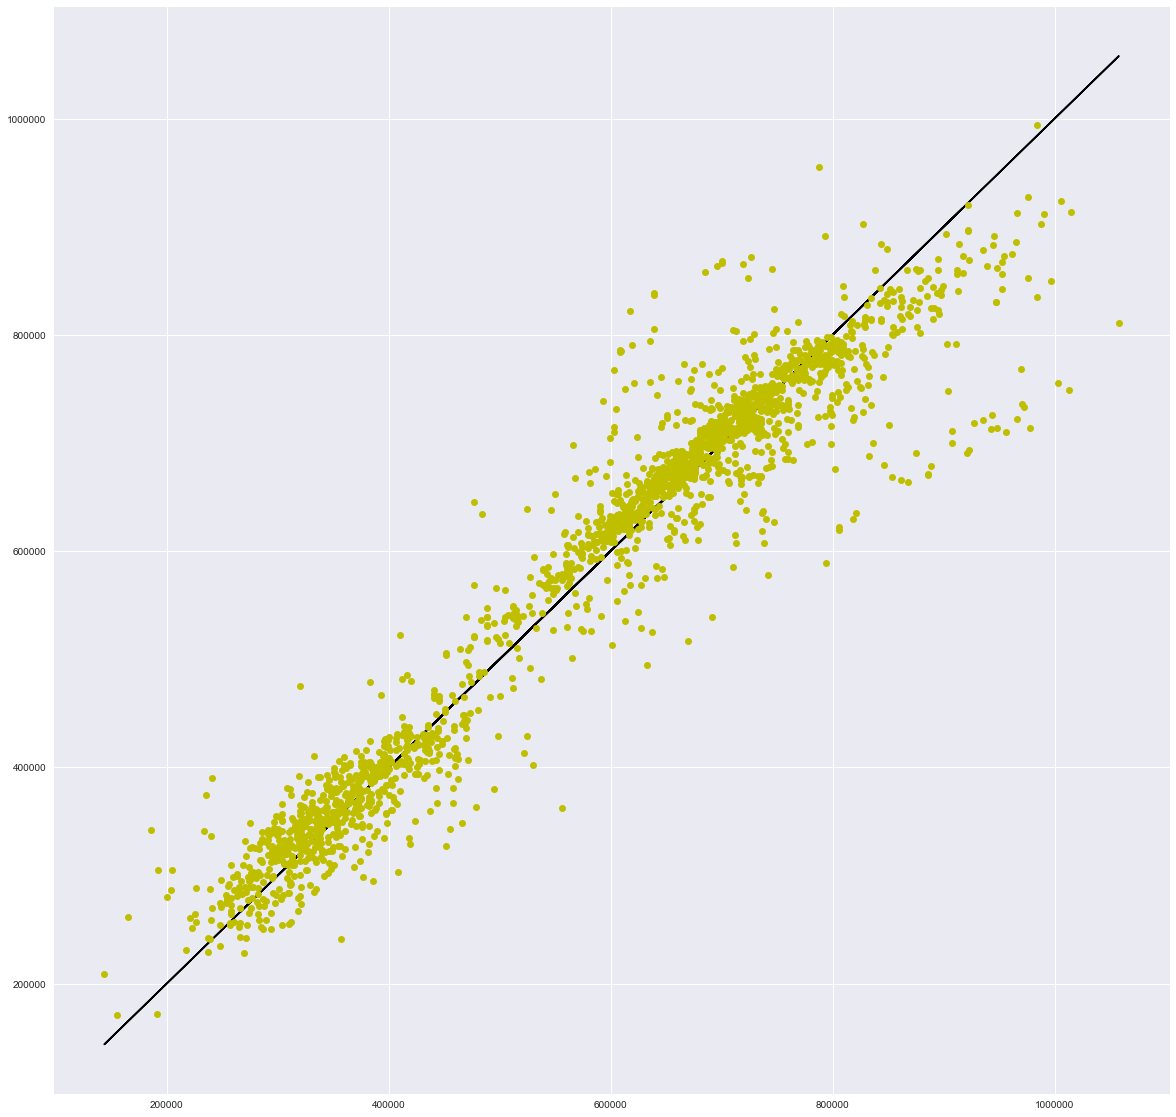

In [97]:
plt.figure(figsize=(20,20))
plt.plot(y_true.values,y_true.values,'k')
plt.plot(y_true.values,y_pred,'yo')



Feature ranking:
1. feature 9 (0.745725)
Type_Video
2. feature 1 (0.068151)
num@s
3. feature 5 (0.034525)
Dunk?
4. feature 0 (0.026415)
Description_Len
5. feature 16 (0.022923)
Month_07
6. feature 6 (0.016106)
Weekday
7. feature 3 (0.012234)
num?s
8. feature 2 (0.005307)
num#s
9. feature 14 (0.004241)
Month_05
10. feature 18 (0.003725)
Month_09
11. feature 11 (0.003601)
Month_02
12. feature 21 (0.003195)
Month_12
13. feature 19 (0.003099)
Month_10
14. feature 48 (0.003051)
Year_2019
15. feature 22 (0.003011)
Hour_00
16. feature 43 (0.002899)
Hour_21
17. feature 17 (0.002835)
Month_08
18. feature 20 (0.002709)
Month_11
19. feature 13 (0.002551)
Month_04
20. feature 10 (0.002481)
Month_01
21. feature 23 (0.002472)
Hour_01
22. feature 41 (0.002445)
Hour_19
23. feature 47 (0.002347)
Year_2018
24. feature 44 (0.002167)
Hour_22
25. feature 40 (0.002107)
Hour_18
26. feature 39 (0.002041)
Hour_17
27. feature 42 (0.002025)
Hour_20
28. feature 46 (0.001904)
Year_2017
29. feature 45 (0.001847)
Ho

(-1, 49)

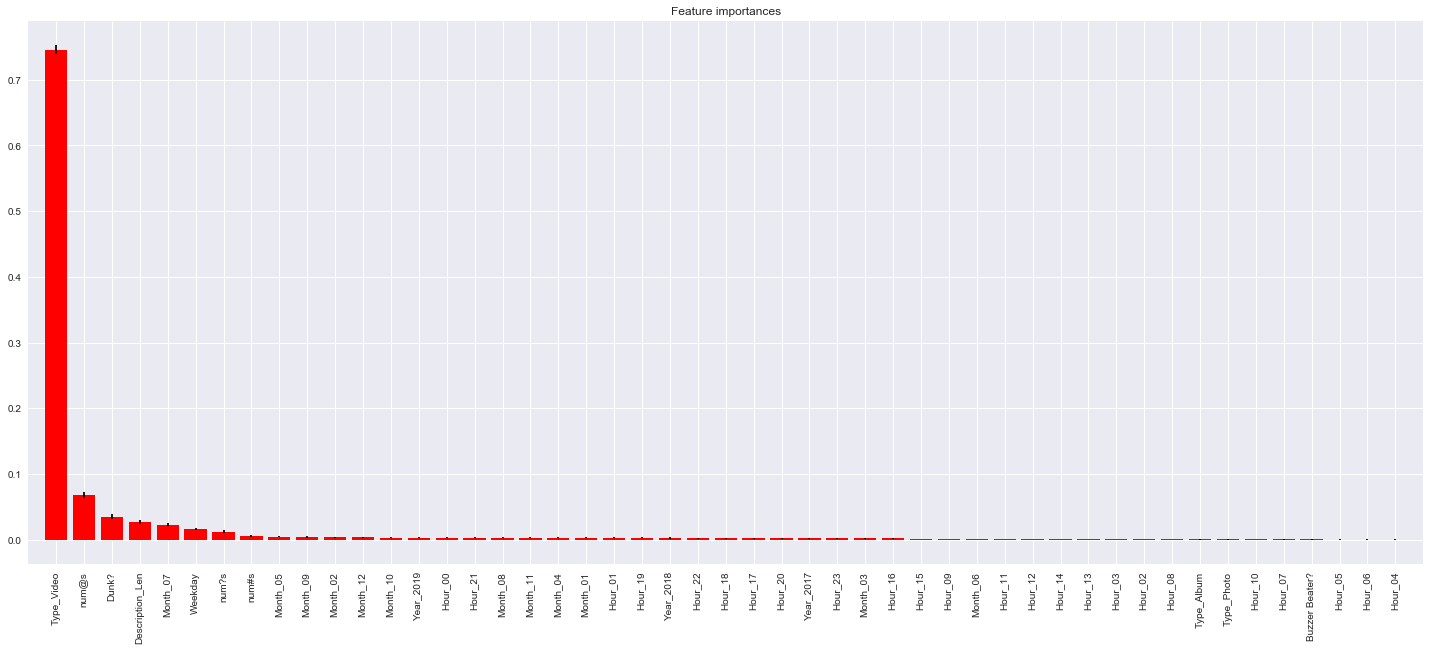

In [85]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features

# Build a forest and compute the feature importances
forest = RandomForestRegressor(n_estimators=250,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
col_names = []
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(X.columns[indices[f]])
    col_names.append(X.columns[indices[f]])

# Plot the feature importances of the forest
plt.figure(figsize=(25,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), col_names,rotation=90)
plt.xlim([-1, X.shape[1]])


In [ ]:
instas.loc[instas['Description'].str.contains('buzzer')]


In [ ]:
importances[indices]

In [ ]:
importances

In [ ]:
model.score(X_test_pca,y_test.values)

In [ ]:
y_true = y_test
y_pred = model.predict(X_test_pca)
y_pred = np.array([round(y) for y in y_pred])
mean_absolute_percentage_error(y_true, y_pred)


In [ ]:
instas